<a href="https://colab.research.google.com/github/Silpa12345/Deep_learning/blob/main/CAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib pillow torchvision torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os
import glob
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF


In [3]:
base_dir = '/content/drive/MyDrive/Project-Landslide/CAS_dataset'

def gather_matched_image_mask_pairs(base_path):
    img_path = os.path.join(base_path, 'img')
    mask_path = os.path.join(base_path, 'mask')

    image_files = sorted(glob.glob(os.path.join(img_path, "*.*")))
    mask_files = sorted(glob.glob(os.path.join(mask_path, "*.*")))

    # Create a mapping based on base filename
    mask_names = {os.path.splitext(os.path.basename(m))[0]: m for m in mask_files}

    matched_images = []
    matched_masks = []

    for img in image_files:
        base = os.path.splitext(os.path.basename(img))[0]
        if base in mask_names:
            matched_images.append(img)
            matched_masks.append(mask_names[base])
        else:
            print(f"Skipping unmatched image: {base}")

    print(f"Matched {len(matched_images)} image-mask pairs.")
    return matched_images, matched_masks

images, masks = gather_matched_image_mask_pairs(base_dir)
print(f"Found {len(images)} images and {len(masks)} masks")


Skipping unmatched image: Hokkaido0080 (1)
Skipping unmatched image: Hokkaido0129 (1)
Skipping unmatched image: Hokkaido0337 (1)
Skipping unmatched image: Hokkaido0580 (1)
Skipping unmatched image: Hokkaido0643 (1)
Skipping unmatched image: Hokkaido0678 (1)
Skipping unmatched image: Hokkaido0868 (1)
Skipping unmatched image: Hokkaido0941 (1)
Skipping unmatched image: Hokkaido0961 (1)
Skipping unmatched image: Hokkaido1076 (1)
Matched 1484 image-mask pairs.
Found 1484 images and 1484 masks


In [4]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42)

def save_dataset(image_paths, mask_paths, out_dir):
    os.makedirs(os.path.join(out_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(out_dir, 'masks'), exist_ok=True)

    for img, mask in zip(image_paths, mask_paths):
        shutil.copy(img, os.path.join(out_dir, 'images', os.path.basename(img)))
        shutil.copy(mask, os.path.join(out_dir, 'masks', os.path.basename(mask)))

save_dataset(train_imgs, train_masks, "dataset/train")
save_dataset(val_imgs, val_masks, "dataset/val")


In [86]:
# ✅ Dataset Class with Proper Mask Binarization
class CASLandslideDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.tif')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB").resize((256, 256))
        image = TF.to_tensor(image)

        mask = Image.open(self.mask_paths[idx]).convert("L").resize((256, 256))
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask


In [88]:
# ✅ IoU and Dice Metric Functions
def dice_score(preds, targets, epsilon=1e-6):
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return (2. * intersection + epsilon) / (union + epsilon)

def iou_score(preds, targets, epsilon=1e-6):
    intersection = (preds & targets).float().sum()
    union = (preds | targets).float().sum()
    return (intersection + epsilon) / (union + epsilon)


In [89]:
import os

# ✅ Define Data Paths
train_img_dir = "dataset/train/images"
train_mask_dir = "dataset/train/masks"
val_img_dir = "dataset/val/images"
val_mask_dir = "dataset/val/masks"

train_dataset = CASLandslideDataset(train_img_dir, train_mask_dir)
val_dataset = CASLandslideDataset(val_img_dir, val_mask_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [90]:
# ✅ Define Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1, encoder_weights="imagenet").to(device)
pos_weight = torch.tensor([5.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [91]:
# ✅ Training Loop
for epoch in range(20):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ✅ Validation
    model.eval()
    val_loss, all_preds, all_masks = 0, [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())

    p = torch.cat(all_preds).view(-1).int()
    t = torch.cat(all_masks).view(-1).int()
    dice = dice_score(p, t)
    iou = iou_score(p, t)

    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss/len(val_loader):.4f}, Dice={dice:.4f}, IoU={iou:.4f}")


Epoch 1: Train Loss=0.6414, Val Loss=0.4145, Dice=0.6947, IoU=0.5322
Epoch 2: Train Loss=0.4032, Val Loss=0.3535, Dice=0.6857, IoU=0.5217
Epoch 3: Train Loss=0.3332, Val Loss=0.3043, Dice=0.7165, IoU=0.5582
Epoch 4: Train Loss=0.2871, Val Loss=0.2572, Dice=0.7694, IoU=0.6252
Epoch 5: Train Loss=0.2540, Val Loss=0.2357, Dice=0.7558, IoU=0.6075
Epoch 6: Train Loss=0.2295, Val Loss=0.2282, Dice=0.7899, IoU=0.6527
Epoch 7: Train Loss=0.2065, Val Loss=0.2072, Dice=0.7723, IoU=0.6291
Epoch 8: Train Loss=0.1863, Val Loss=0.1871, Dice=0.8086, IoU=0.6788
Epoch 9: Train Loss=0.1709, Val Loss=0.1793, Dice=0.8298, IoU=0.7091
Epoch 10: Train Loss=0.1571, Val Loss=0.1684, Dice=0.8080, IoU=0.6778
Epoch 11: Train Loss=0.1423, Val Loss=0.1579, Dice=0.8418, IoU=0.7268
Epoch 12: Train Loss=0.1332, Val Loss=0.1538, Dice=0.8506, IoU=0.7400
Epoch 13: Train Loss=0.1262, Val Loss=0.1470, Dice=0.8601, IoU=0.7545
Epoch 14: Train Loss=0.1157, Val Loss=0.1399, Dice=0.8631, IoU=0.7592
Epoch 15: Train Loss=0.1081, 

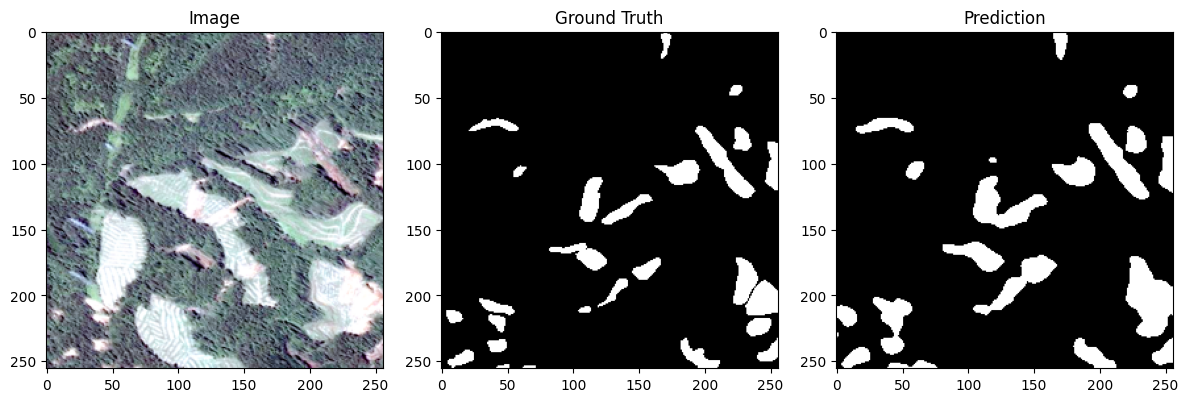

In [92]:

# ✅ Visualize Prediction
model.eval()
sample_image, sample_mask = val_dataset[0]
with torch.no_grad():
    output = model(sample_image.unsqueeze(0).to(device))
    pred = torch.sigmoid(output).squeeze().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(sample_image.permute(1, 2, 0)); plt.title("Image")
plt.subplot(1, 3, 2); plt.imshow(sample_mask.squeeze(), cmap="gray"); plt.title("Ground Truth")
plt.subplot(1, 3, 3); plt.imshow(pred > 0.3, cmap="gray"); plt.title("Prediction")
plt.tight_layout(); plt.show()
